## 라이브러리 추가

In [ ]:
import os
import numpy as np
import pathlib
import librosa
import librosa.display
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from torchvision import models, transforms
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sb
from tqdm import tqdm
import soundfile as sf
from audiomentations import Compose, AddGaussianNoise, PitchShift, HighPassFilter
import random

## 함수 및 클래스 정의

In [9]:
# 기본 설정
target_sample_rate = 16000
# 최대 5초
img_height, img_width = 128, 431
batch_size = 16
hop_length = 256

# GPU 메모리 비우기
torch.cuda.empty_cache()

# CUDA 설정
os.environ["CUDA_LAUNCH_BLOCKING"] = "1"

# 올바른 장치 설정
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

# 학습 함수
def train(model, train_loader, criterion, optimizer):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    for inputs, labels in tqdm(train_loader, desc="Training", leave=False):
        inputs, labels = inputs.to(device), labels.to(device).long()

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * inputs.size(0)
        preds = torch.argmax(outputs, dim=1)
        correct += (preds == labels).sum().item()
        total += labels.size(0)
    
    accuracy = correct / total
    return running_loss / len(train_loader.dataset), accuracy

# 평가 함수
def validate(model, val_loader, criterion):
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0
    all_preds = []
    all_labels = []
    with torch.no_grad():
        for inputs, labels in tqdm(val_loader, desc="Validation", leave=False):
            inputs, labels = inputs.to(device), labels.to(device).long()

            outputs = model(inputs)
            loss = criterion(outputs, labels)

            running_loss += loss.item() * inputs.size(0)
            preds = torch.argmax(outputs, dim=1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    accuracy = correct / total
    return running_loss / len(val_loader.dataset), accuracy, all_preds, all_labels


# 음성 -> 멜스펙토그램 변환
def audio_to_melspectrogram(signal, sr, n_mels=128, fmax=8000):
    mel_spec = librosa.feature.melspectrogram(y=signal, sr=sr, n_mels=n_mels, fmax=fmax, hop_length=hop_length)
    mel_spec_db = librosa.power_to_db(mel_spec, ref=np.max)
    return mel_spec_db

# 윈도잉 기법 사용
def split_audio_into_windows(signal, sr, window_size=1.0, hop_size=0.5):
    window_samples = int(window_size * sr)
    hop_samples = int(hop_size * sr)
    windows = []
    for start in range(0, len(signal) - window_samples + 1, hop_samples):
        end = start + window_samples
        windows.append(signal[start:end])
    return windows

# 아기 울음 소리가 있는 윈도우인지 확인. RMS 사용
def is_crying_window(window, sr, threshold=0.01):
    rms = librosa.feature.rms(y=window)[0]
    return np.max(rms) > threshold

# 음성 전처리.
# 윈도잉 기법 사용 후 아이 울음소리부분만 학습
def preprocess_audio_with_windows(file_path, sample_rate=16000, window_size=1.0, hop_size=0.5):
    signal, sr = librosa.load(file_path, sr=sample_rate)
    if len(signal) == 0:
        return None

    windows = split_audio_into_windows(signal, sr, window_size, hop_size)
    selected_windows = [window for window in windows if is_crying_window(window, sr)]

    # 울음소리 감지안되면 None 리턴
    if len(selected_windows) == 0:
        return None

    # 울음소리 시작 윈도우 찾기
    start_index = next((i for i, window in enumerate(windows) if is_crying_window(window, sr)), None)
    if start_index is None:
        return None

    # 선택된 첫 번째 윈도우를 Mel-spectrogram으로 변환
    mel_spec = audio_to_melspectrogram(windows[start_index], sr)
    if mel_spec.shape[1] > img_width:
        mel_spec = mel_spec[:, :img_width]
    else:
        mel_spec = np.pad(mel_spec, ((0, 0), (0, img_width - mel_spec.shape[1])), 'constant')

    return mel_spec

# 멜스펙트로그램 추출
def extract_features(files):
    print("특징 추출 시작")
    X = []
    Y = []
    for f in tqdm(files, total=len(files)):
        mel_spec = preprocess_audio_with_windows(f)
        if mel_spec is not None:
            X.append(mel_spec)
            label = str(f.parent.stem)
            Y.append(label)

    X = np.array(X)
    Y = np.array(Y)
    print("특징 추출 완료")
    return X, Y

# 데이터 증강
def augment_data(audioFileNames, classes, save_path):
    print("데이터 증강 시작")
    obj = audioPreprocessing()
    dictionary = {'pain': 13, 'discomfort': 45, 'hungry': 308, 'tired': 24}
    print("증강 전: ", len(audioFileNames))
    for idx, x in tqdm(enumerate(audioFileNames), total=len(audioFileNames)):
        signal_org = obj.readAudio(x)
        cc = pathlib.Path(save_path) / "/".join(str(x).split(os.sep)[1:])
        cc.parent.mkdir(parents=True, exist_ok=True)
        # hungry 제외
        if classes[idx] == "hungry":
            sf.write(cc, signal_org, target_sample_rate)
        # 나머지는 hungry 개수만큼 증강
        else:
            augmentation_num = 308 // dictionary[classes[idx]]
            for i in range(augmentation_num):
                path_to_save = cc.with_name(f"{cc.stem}_{idx}_{i}{cc.suffix}")
                augmented_signal = obj.audioAugmentation(signal_org, [0])
                sf.write(path_to_save, augmented_signal, target_sample_rate)
            sf.write(cc, signal_org, target_sample_rate)
    print("After augmentation:", len(list(pathlib.Path(save_path).rglob("*.wav"))))
    print("데이터 증강 완료")

# 음성 전처리 클래스
class audioPreprocessing:
    def __init__(self, sample_rate=22050):
        self.sample_rate = sample_rate

    def readAudio(self, fileName):
        signal, sr = librosa.load(fileName, sr=self.sample_rate)
        return signal

    # 증강로직(논문 참고)
    def audioAugmentation(self, signal, i):
        aug_transform = []
        aug_transform1 = [
            AddGaussianNoise(min_amplitude=0.01, max_amplitude=0.015, p=1),
            PitchShift(min_semitones=-2, max_semitones=2, p=1),
            HighPassFilter(min_cutoff_freq=3000, max_cutoff_freq=4000, p=1)
        ]
        for j in i:
            aug_transform.append(aug_transform1[j])
        augment_raw_audio = Compose(aug_transform)
        augmented_signal = augment_raw_audio(signal, self.sample_rate)
        return augmented_signal

# 폴더 밑에 있는 wav파일 로드
def load_data(path):
    print(f"{path}에서 데이터 로딩 중")
    audio_files = sorted(list(pathlib.Path(path).rglob("*.wav")))
    classes = [str(f.parent).split(os.sep)[-1] for f in audio_files]
    print(f"데이터 로딩 완료: 총 {len(audio_files)}개의 파일")
    return audio_files, classes

# 데이터셋 클래스
class CryingDataset(Dataset):
    def __init__(self, files, labels, label_encoder, transform=None):
        self.files = files
        self.labels = labels
        self.label_encoder = label_encoder
        self.transform = transform
        self.filtered_files_labels = [
            (file, label) for file, label in zip(files, labels)
            if preprocess_audio_with_windows(file) is not None
        ]

    def __len__(self):
        return len(self.filtered_files_labels)

    def __getitem__(self, idx):
        file, label = self.filtered_files_labels[idx]
        mel_spec = preprocess_audio_with_windows(file)
        if self.transform:
            mel_spec = self.transform(mel_spec)
        label = self.label_encoder.transform([label])[0]
        return mel_spec, label

# 모델 입력을 위한 텐서 변환 클래스
class MelSpecToTensor:
    def __call__(self, mel_spec):
        mel_spec = torch.tensor(mel_spec, dtype=torch.float32)
        mel_spec = mel_spec.unsqueeze(0)  # Add channel dimension
        mel_spec = mel_spec.repeat(3, 1, 1)  # Repeat across the channel dimension to make it 3 channels
        return mel_spec

# resnet 클래스, 과적합 방지 드롭아웃 추가
class CryingResNet(nn.Module):
    def __init__(self, num_classes):
        super(CryingResNet, self).__init__()
        self.base_model = models.resnet50(pretrained=True)
        self.base_model.fc = nn.Sequential(
            nn.Dropout(0.5),
            nn.Linear(self.base_model.fc.in_features, num_classes)
        )

    def forward(self, x):
        return self.base_model(x)

cuda


## 데이터 학습 시작

dataset/original에서 데이터 로딩 중
데이터 로딩 완료: 총 390개의 파일
데이터 증강 시작
증강 전:  390


100%|████████████████████████████████████████████████████████████████████████████████| 390/390 [00:13<00:00, 28.52it/s]


After augmentation: 1247
데이터 증강 완료
dataset/augmented에서 데이터 로딩 중
데이터 로딩 완료: 총 1247개의 파일
모델 학습 시작
에폭 1/50 시작


Epoch 1/50, Train Loss: 1.1121, Train Accuracy: 0.4985, Val Loss: 1.2329, Val Accuracy: 0.4520
모델 저장: 성능 향상됨
에폭 2/50 시작


Epoch 2/50, Train Loss: 0.9679, Train Accuracy: 0.6000, Val Loss: 1.0067, Val Accuracy: 0.5400
모델 저장: 성능 향상됨
에폭 3/50 시작


Epoch 3/50, Train Loss: 0.9235, Train Accuracy: 0.6070, Val Loss: 1.1564, Val Accuracy: 0.5600
에폭 4/50 시작


Epoch 4/50, Train Loss: 0.7484, Train Accuracy: 0.7156, Val Loss: 0.9507, Val Accuracy: 0.5640
모델 저장: 성능 향상됨
에폭 5/50 시작


Epoch 5/50, Train Loss: 0.7282, Train Accuracy: 0.7367, Val Loss: 0.7980, Val Accuracy: 0.7200
모델 저장: 성능 향상됨
에폭 6/50 시작


Epoch 6/50, Train Loss: 0.6379, Train Accuracy: 0.7578, Val Loss: 0.8758, Val Accuracy: 0.6360
에폭 7/50 시작


Epoch 7/50, Train Loss: 0.6593, Train Accuracy: 0.7497, Val Loss: 0.4034, Val Accuracy: 0.8480
모델 저장: 성능 향상됨
에폭 8/50 시작


Epoch 8/50, Train Loss: 0.4964, Train Accuracy: 0.8151, Val Loss: 0.4204, Val Accuracy: 0.8720
에폭 9/50 시작


Epoch 9/50, Train Loss: 0.4027, Train Accuracy: 0.8583, Val Loss: 0.3234, Val Accuracy: 0.8560
모델 저장: 성능 향상됨
에폭 10/50 시작


Epoch 10/50, Train Loss: 0.3595, Train Accuracy: 0.8774, Val Loss: 0.5611, Val Accuracy: 0.8120
에폭 11/50 시작


Epoch 11/50, Train Loss: 0.4001, Train Accuracy: 0.8583, Val Loss: 0.2971, Val Accuracy: 0.8960
모델 저장: 성능 향상됨
에폭 12/50 시작


Epoch 12/50, Train Loss: 0.2515, Train Accuracy: 0.9146, Val Loss: 0.3862, Val Accuracy: 0.9000
에폭 13/50 시작


Epoch 13/50, Train Loss: 0.2393, Train Accuracy: 0.9176, Val Loss: 0.3407, Val Accuracy: 0.8920
에폭 14/50 시작


Epoch 14/50, Train Loss: 0.2889, Train Accuracy: 0.9015, Val Loss: 0.4097, Val Accuracy: 0.9000
에폭 15/50 시작


Epoch 15/50, Train Loss: 0.2598, Train Accuracy: 0.9156, Val Loss: 0.2721, Val Accuracy: 0.9000
모델 저장: 성능 향상됨
에폭 16/50 시작


Epoch 16/50, Train Loss: 0.2445, Train Accuracy: 0.9116, Val Loss: 0.2935, Val Accuracy: 0.9080
에폭 17/50 시작


Epoch 17/50, Train Loss: 0.2327, Train Accuracy: 0.9246, Val Loss: 0.2845, Val Accuracy: 0.8840
에폭 18/50 시작


Epoch 18/50, Train Loss: 0.1659, Train Accuracy: 0.9377, Val Loss: 0.2343, Val Accuracy: 0.9240
모델 저장: 성능 향상됨
에폭 19/50 시작


Epoch 19/50, Train Loss: 0.1272, Train Accuracy: 0.9538, Val Loss: 0.1543, Val Accuracy: 0.9440
모델 저장: 성능 향상됨
에폭 20/50 시작


Epoch 20/50, Train Loss: 0.1838, Train Accuracy: 0.9377, Val Loss: 0.3338, Val Accuracy: 0.8840
에폭 21/50 시작


Epoch 21/50, Train Loss: 0.3405, Train Accuracy: 0.8744, Val Loss: 0.3836, Val Accuracy: 0.8960
에폭 22/50 시작


Epoch 22/50, Train Loss: 0.1877, Train Accuracy: 0.9417, Val Loss: 0.2273, Val Accuracy: 0.9240
에폭 23/50 시작


Epoch 23/50, Train Loss: 0.1254, Train Accuracy: 0.9578, Val Loss: 0.3040, Val Accuracy: 0.9280
에폭 24/50 시작


Epoch 24/50, Train Loss: 0.2292, Train Accuracy: 0.9317, Val Loss: 0.2433, Val Accuracy: 0.9280
에폭 25/50 시작


Epoch 25/50, Train Loss: 0.1087, Train Accuracy: 0.9618, Val Loss: 0.2357, Val Accuracy: 0.9240
에폭 26/50 시작


Epoch 26/50, Train Loss: 0.0960, Train Accuracy: 0.9668, Val Loss: 0.1990, Val Accuracy: 0.9480
에폭 27/50 시작


Epoch 27/50, Train Loss: 0.1018, Train Accuracy: 0.9698, Val Loss: 0.3034, Val Accuracy: 0.9200
에폭 28/50 시작


Epoch 28/50, Train Loss: 0.0895, Train Accuracy: 0.9739, Val Loss: 0.2121, Val Accuracy: 0.9320
에폭 29/50 시작


Epoch 29/50, Train Loss: 0.0678, Train Accuracy: 0.9759, Val Loss: 0.4421, Val Accuracy: 0.9040
Early stopping!


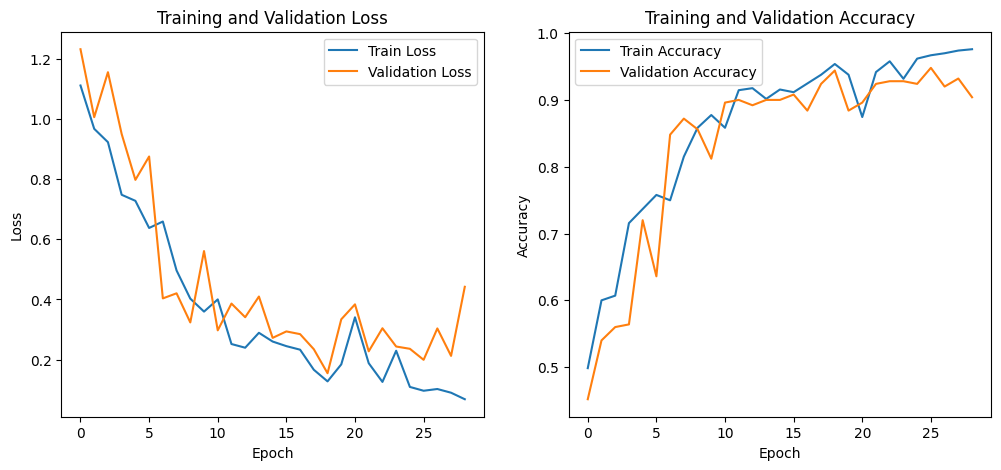

In [10]:
original_audio_dataset = 'dataset/original'
aug_audio_dataset = 'dataset/augmented'

# 데이터 로딩
audio_files, classes = load_data(original_audio_dataset)

# 데이터 증강
augment_data(audio_files, classes, aug_audio_dataset)

# 데이터 로딩
audio_files, classes = load_data(aug_audio_dataset)
X_train_files, X_test_files, Y_train, Y_test = train_test_split(audio_files, classes, test_size=0.2, random_state=42, stratify=classes)

label_encoder = LabelEncoder()
label_encoder.fit(Y_train + Y_test)

# 정규화
transform = transforms.Compose([
    MelSpecToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

# 데이터셋 준비
train_dataset = CryingDataset(X_train_files, Y_train, label_encoder, transform=transform)
test_dataset = CryingDataset(X_test_files, Y_test, label_encoder, transform=transform)

# 데이터 로더 준비
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

model = CryingResNet(num_classes=len(label_encoder.classes_)).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)


# 학습 및 검증 손실, 정확도 기록
train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []

# 학습 및 평가 출력
print("모델 학습 시작")
best_val_loss = float('inf')
early_stopping_patience = 10
epochs_no_improve = 0
num_epochs = 50

for epoch in range(num_epochs):
    print(f"에폭 {epoch+1}/{num_epochs} 시작")
    train_loss, train_accuracy = train(model, train_loader, criterion, optimizer)
    val_loss, val_accuracy, val_preds, val_labels = validate(model, test_loader, criterion)

    train_losses.append(train_loss)
    val_losses.append(val_loss)
    train_accuracies.append(train_accuracy)
    val_accuracies.append(val_accuracy)

    print(f'Epoch {epoch+1}/{num_epochs}, Train Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy:.4f}, Val Loss: {val_loss:.4f}, Val Accuracy: {val_accuracy:.4f}')

    if val_loss < best_val_loss:
        best_val_loss = val_loss
        torch.save(model.state_dict(), 'analyzeCrying.pth')
        epochs_no_improve = 0
        print("모델 저장: 성능 향상됨")
    else:
        epochs_no_improve += 1

    if epochs_no_improve >= early_stopping_patience:
        print('Early stopping!')
        break

# 손실과 정확도 그래프
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Training and Validation Loss')

plt.subplot(1, 2, 2)
plt.plot(train_accuracies, label='Train Accuracy')
plt.plot(val_accuracies, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Training and Validation Accuracy')

plt.show()

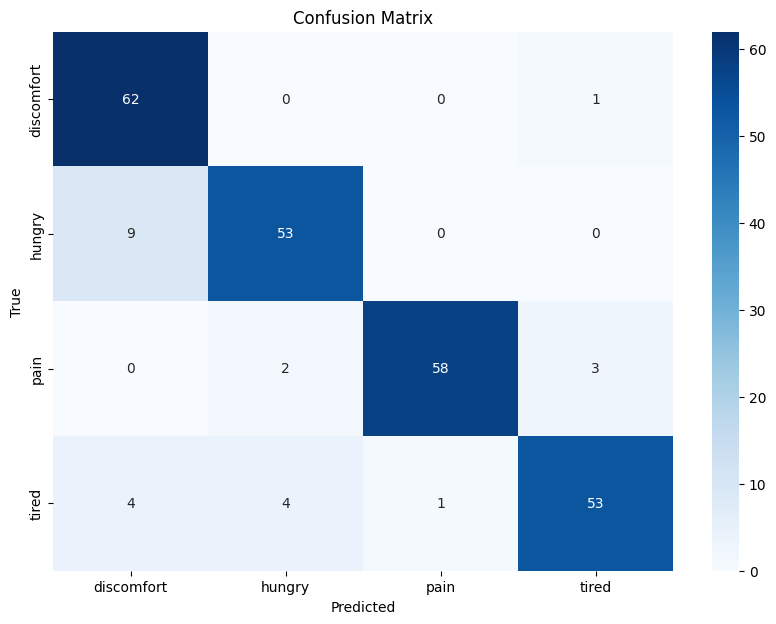

In [11]:
# 혼동 행렬 시각화
conf_matrix = confusion_matrix(val_labels, val_preds)
plt.figure(figsize=(10, 7))
sb.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

## 결과보고서

In [12]:
print('Classification Report:')
print(classification_report(val_labels, val_preds, target_names=label_encoder.classes_))

Classification Report:
              precision    recall  f1-score   support

  discomfort       0.83      0.98      0.90        63
      hungry       0.90      0.85      0.88        62
        pain       0.98      0.92      0.95        63
       tired       0.93      0.85      0.89        62

    accuracy                           0.90       250
   macro avg       0.91      0.90      0.90       250
weighted avg       0.91      0.90      0.90       250



## 테스트 코드

In [19]:
# import random

# def evaluate_random_samples(model, test_files, test_labels, label_encoder, num_samples=5):
#     model.eval()
#     sampled_indices = random.sample(range(len(test_files)), num_samples)
#     sampled_files = [test_files[i] for i in sampled_indices]
#     sampled_labels = [test_labels[i] for i in sampled_indices]

#     with torch.no_grad():
#         for i, (file, true_label) in enumerate(zip(sampled_files, sampled_labels)):
#             mel_spec = preprocess_audio_with_windows(file)
#             if mel_spec is not None:
#                 mel_spec = torch.tensor(mel_spec, dtype=torch.float32).unsqueeze(0).repeat(3, 1, 1)  # Convert to tensor and repeat channels
#                 mel_spec = transforms.Normalize((0.5,), (0.5,))(mel_spec)  # Apply normalization
#                 mel_spec = mel_spec.unsqueeze(0).to(device)  # Add batch dimension and move to device
#                 output = model(mel_spec)
#                 pred_label = torch.argmax(output, dim=1).item()
#                 predicted_class = label_encoder.inverse_transform([pred_label])[0]
#                 true_class = true_label  # true_label이 이미 인코딩된 상태라면 그대로 사용
#                 print(f"Sample {i+1}:")
#                 print(f"  File: {file}")
#                 print(f"  True Label: {true_class}")
#                 print(f"  Predicted Label: {predicted_class}")
#                 print()

# # 테스트셋의 레이블을 먼저 인코딩된 상태로 변환
# Y_test_encoded = label_encoder.transform(Y_test)

# # 학습 후 테스트셋 중 랜덤으로 5개를 뽑아서 평가
# evaluate_random_samples(model, X_test_files, Y_test_encoded, label_encoder, num_samples=5)

Sample 1:
  File: dataset\augmented\original\pain\d6cda191-4962-4308-9a36-46d5648a95ed-1431700390946-1.7-m-04-bp_365_4.wav
  True Label: 2
  Predicted Label: pain

Sample 2:
  File: dataset\augmented\original\pain\69BDA5D6-0276-4462-9BF7-951799563728-1436936185-1.1-m-26-bp_359_21.wav
  True Label: 2
  Predicted Label: pain

Sample 3:
  File: dataset\augmented\original\tired\B2AABCE0-1F62-4B57-B58A-308959ABDFE7-1437188766-1.1-m-26-ti_377_0.wav
  True Label: 3
  Predicted Label: tired

Sample 4:
  File: dataset\augmented\original\hungry\2562ad82-485a-44c2-ad25-f70fce71480b-1430045593479-1.7-m-72-hu.wav
  True Label: 1
  Predicted Label: hungry

Sample 5:
  File: dataset\augmented\original\tired\cecd525b-18fd-49e3-b2b9-dfb08b93ad95-1430110029205-1.7-m-26-ti_383_4.wav
  True Label: 3
  Predicted Label: discomfort

